In [ ]:
#Gabriel 6/1/2022

# Ignorar

In [ ]:
#hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [ ]:
#hide
# from fastbook import *

# Guardar en Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Metadata](#meta)
- [5 - Carga de imágenes y metadata](#carga)
- [6 - Preprocesamieto de las imágenes](#prepro)
- [7 - Train/Test split](#traintest)
- [8 - Modelo](#model)

<a name='lib'></a>
## Librerías

In [1]:
from fastai.vision.all import *
from utils_ATSIA import *

import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [2]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]
caracteristicas = {"AmpollaRectal" :["GG", "N"], #"Gregarinas Gametocistos, Nemátodos"
                   "Branquias" : ["S", "M", "N", "P", "AF"],# "Suciedad, Melanización, Necrosis, Protozoarios y Algas Filamentosas"
                   "Hepatopancreas" : ["DT", "DC", "L", "M", "N"], #"Deformidad Tubular, Desprendimiento Celular, Lípidos, Melanización y Necrosis"
                   "Intestino" : ["GT" "GG", "N", "A", "RC"], #"Gregarinas Trofozoito, Gregarina Gametocistos, Nemátodos, Algas y Restos de Crustaceos"
                   "Uropodo" : ["Prem", "Muda", "Post", "Inte"]}

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 26, "Intestino" : 27, "Uropodo" :4}

In [3]:
main_path = Path(os.getcwd()) #Cuando estemos en local
Path.BASE_PATH = main_path
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos: 
    if not os.path.exists(Path(os.path.join("data", organo))):
        os.mkdir(Path(os.path.join("data", organo)))
        
    if not os.path.exists(Path(os.path.join("img", organo))):
        os.mkdir(Path(os.path.join("img", organo)))

    if not os.path.exists(Path(os.path.join("metadata", organo))):
        os.mkdir(Path(os.path.join("metadata", organo)))

for organo in organos:
    path["data"][organo] = Path(os.path.join("data", organo, f"X_{organo}.npy"))
    path["img"][organo] = Path(os.path.join("img", organo))
    path["metadata"][organo] = Path(os.path.join("metadata", organo, f"metadata_{organo}.csv"))

In [ ]:
# SIZE = 200

<a name='eda'></a>
## Análisis Exploratorio de Datos (EDA)

In [4]:
count = get_img_count(organos, organo_len, caracteristicas, grados, path)

100%|██████████| 5/5 [00:00<00:00, 66.79it/s]


No hay imágenes en la carpeta img\AmpollaRectal
No hay imágenes en la carpeta img\Branquias


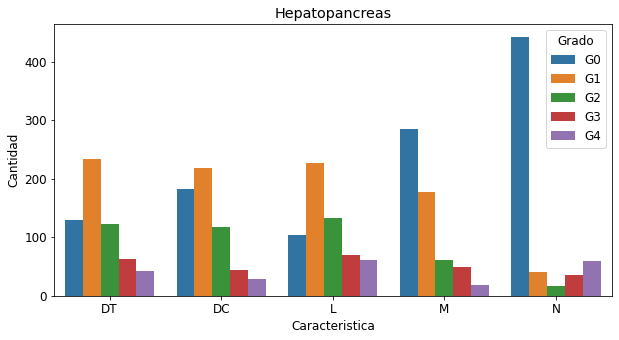

No hay imágenes en la carpeta img\Intestino
No hay imágenes en la carpeta img\Uropodo


In [5]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Caracteristica", y = "Cantidad", hue = "Grado")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")

No hay imágenes en la carpeta img\AmpollaRectal
No hay imágenes en la carpeta img\Branquias


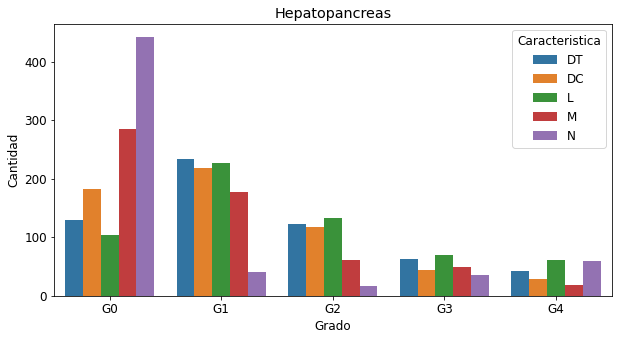

No hay imágenes en la carpeta img\Intestino
No hay imágenes en la carpeta img\Uropodo


In [6]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Grado", y = "Cantidad", hue = "Caracteristica")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")


<a name='meta'></a>
## Metada

In [7]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [8]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata

,img_name,labels
0,DT_G0-DC_G0-L_G0-M_G0-N_G0 (10).png,DT_G0 DC_G0 L_G0 M_G0 N_G0
1,DT_G0-DC_G0-L_G0-M_G0-N_G0 (11).png,DT_G0 DC_G0 L_G0 M_G0 N_G0
2,DT_G0-DC_G0-L_G0-M_G0-N_G0 (12).png,DT_G0 DC_G0 L_G0 M_G0 N_G0
3,DT_G0-DC_G0-L_G0-M_G0-N_G0 (13).png,DT_G0 DC_G0 L_G0 M_G0 N_G0
4,DT_G0-DC_G0-L_G0-M_G0-N_G0 (14).png,DT_G0 DC_G0 L_G0 M_G0 N_G0
...,...,...
587,DT_G4-DC_G4-L_G4-M_G4-N_G4 (4).png,DT_G4 DC_G4 L_G4 M_G4 N_G4
588,DT_G4-DC_G4-L_G4-M_G4-N_G4 (5).png,DT_G4 DC_G4 L_G4 M_G4 N_G4
589,DT_G4-DC_G4-L_G4-M_G4-N_G4 (6).png,DT_G4 DC_G4 L_G4 M_G4 N_G4
590,DT_G4-DC_G4-L_G4-M_G4-N_G4 (7).png,DT_G4 DC_G4 L_G4 M_G4 N_G4


<a name='carga'></a> 
## Carga de imágenes y metadata 

In [9]:
metadata_csv = pd.read_csv(path["metadata"][organo], sep = ",")
metadata_csv.sample(3)

,img_name,labels
499,DT_G3-DC_G1-L_G1-M_G0-N_G4.png,DT_G3 DC_G1 L_G1 M_G0 N_G4
587,DT_G4-DC_G4-L_G4-M_G4-N_G4 (4).png,DT_G4 DC_G4 L_G4 M_G4 N_G4
195,DT_G1-DC_G0-L_G4-M_G2-N_G4.png,DT_G1 DC_G0 L_G4 M_G2 N_G4


### Constructing a DataBlock

In [ ]:
# # check for mislabelled data
# b = []

# for i,v in enumerate(metadata_csv["labels"]):
#     a = v.split(" ")
#     for val in a:
#         if val not in b:
#             b.append(val)
#             if val == "N_G0.":
#                 print(v)
# b

In [ ]:
img = PILImage(PILImage.create("TEST_IMAGE.png").resize((600,400)))
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

In [ ]:
tfms = aug_transforms(mult=1.0, 
                      do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10.0, 
                      min_zoom=1.0, 
                      max_zoom=1.2, 
                      max_lighting=0.1, 
                      max_warp=0.1, 
                      p_affine=0.75, 
                      p_lighting=0.75, 
                      xtra_tfms=None, 
                      mode='bilinear', 
                      pad_mode='reflection', 
                      align_corners=True, 
                      batch=False, 
                      min_scale=1.0)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(3,3, figsize=(15,10))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [ ]:
RandomSplitter??

In [ ]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(" ")


dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y, 
                   item_tfms = Resize(500),
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
#                    batch_tfms = Normalize.from_stats(*imagenet_stats)
#                    batch_tfms =[*aug_transforms(mult=1.0,
#                                               do_flip=True,
#                                               flip_vert=True,
#                                               max_rotate=10.0, 
#                                               min_zoom=1.0, 
#                                               max_zoom=1.2, 
#                                               max_lighting=0.1, 
#                                               max_warp=0.1, 
#                                               p_affine=0.75, 
#                                               p_lighting=0.75,  
#                                               mode='bilinear', 
#                                               pad_mode='reflection', 
#                                               align_corners=True, 
#                                               batch=False, 
#                                               min_scale=1.0),Normalize.from_stats(*imagenet_stats)]
                   )
dsets = dblock.datasets(metadata_csv)
dsets.train[0]
# dsets.valid[0]

In [ ]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

And now we can display a sample of our data:

In [ ]:
dls = dblock.dataloaders(metadata_csv, bs=16)

In [ ]:
dls.show_batch(nrows=1, ncols=3, figsize=(15,10))

In [ ]:
dls.valid.items

### Binary Cross-Entropy

In [72]:
# #Vieja
# def atsia_acc(preds, targs):
#     columns= ["acc_dc","acc_dt", "acc_l", "acc_m", "acc_n"]
#     acc = pd.DataFrame(np.zeros((len(preds), len(columns))), columns = columns)
#     for i in range(0, len(preds)):
        
#         cat1_preds = preds[i][:5]
#         cat1_targs = targs[i][:5]

#         cat2_preds = preds[i][5:10]
#         cat2_targs = targs[i][5:10]

#         cat3_preds = preds[i][10:15]
#         cat3_targs = targs[i][10:15]

#         cat4_preds = preds[i][15:20]
#         cat4_targs = targs[i][15:20]

#         cat5_preds = preds[i][20:]
#         cat5_targs = targs[i][20:]
        
#         if torch.eq(cat1_preds.argmax(), cat1_targs.argmax()):
#             acc["acc_dc"][i] = 1
#         if torch.eq(cat2_preds.argmax(), cat2_targs.argmax()):
#             acc["acc_dt"][i] = 1
#         if torch.eq(cat3_preds.argmax(), cat3_targs.argmax()):
#             acc["acc_l"][i] = 1 
#         if torch.eq(cat4_preds.argmax(), cat4_targs.argmax()):
#             acc["acc_m"][i] = 1
#         if torch.eq(cat5_preds.argmax(), cat5_targs.argmax()):
#             acc["acc_n"][i] = 1
        
#     return acc.describe().loc["mean"].mean()

In [ ]:
# #Vieja
# class BCEWithLogitsLossFlat_atsia(BaseLoss):
#     '''FOR USE OF ATSIA: Same as `nn.BCEWithLogitsLoss`, but flattens input and target.'''
    
#     @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
#     def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
#         if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
#             raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
#         if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
#         super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
#         self.thresh = thresh

#     def preds_norm(preds):
#         cat = np.array(np.zeros(preds.shape))

#         for i in range(0, len(preds)):

#             cat1_preds = preds[i][:5]
#             cat2_preds = preds[i][5:10]
#             cat3_preds = preds[i][10:15]
#             cat4_preds = preds[i][15:20]
#             cat5_preds = preds[i][20:]

#             cat1_preds_new = np.zeros(len(cat1_preds))
#             cat1_preds_new[cat1_preds.argmax()] = 1
#             cat2_preds_new = np.zeros((len(cat2_preds)))
#             cat2_preds_new[cat2_preds.argmax()] = 1
#             cat3_preds_new = np.zeros((len(cat3_preds)))
#             cat3_preds_new[cat3_preds.argmax()] = 1
#             cat4_preds_new = np.zeros((len(cat4_preds)))
#             cat4_preds_new[cat4_preds.argmax()] = 1
#             cat5_preds_new = np.zeros((len(cat5_preds)))
#             cat5_preds_new[cat5_preds.argmax()] = 1
            
#             cat[i] = np.concatenate((cat1_preds_new, cat2_preds_new, cat3_preds_new, cat4_preds_new, cat5_preds_new), axis = 0)
            
#         return cat
    
#     def decodes(self, x):    
#         preds_norm_1 = preds_norm(x)
#         preds_norm_1 = torch.from_numpy(preds_norm_1)
#         return preds_norm_1>self.thresh
    
#     def activation(self, x): return torch.sigmoid(x)

In [71]:
#Nueva
def get_info():
    return organo, caracteristicas, grados

def atsia_acc(y_pred, y):
    organo, caracteristicas, grados = get_info()
    columns = []
    for caracteristica in caracteristicas[organo]:
        columns.append(f"ACC_{caracteristica}")
    #Al final columns vendrá en la forma columns = ["ACC_DT", "ACC_DC", "ACC_L", "ACC_M", "ACC_N"] para Hepatopancreas

    acc = pd.DataFrame(np.zeros((len(y_pred), len(columns))), columns = columns)

    for i in range(0, len(y_pred)):
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                preds = y_pred[i][len(grados)*j : len(grados)*(j+1)]
                targs = y[i][len(grados)*j : len(grados)*(j+1)]

            else:
                preds = y_pred[i][len(grados)*j :]
                targs = y[i][len(grados)*j :]

            if torch.eq(preds.argmax(), targs.argmax()):
                acc[f"ACC_{caracteristica}"][i] = 1
                
    return acc.describe().loc["mean"].mean()

In [82]:
#Nuevo
class BCEWithLogitsLossFlat_atsia(BaseLoss):
    '''FOR USE OF ATSIA: Same as `nn.BCEWithLogitsLoss`, but flattens input and target.
    * Se modificó la función __init__ para que tenga en consideración las caracteristicas y el 
      organo que se está evaluando.
    *  Se modificó la función decodes para satisfacer las necesidades del proyecto de siempre
      predicir 1 etiqueta (grado) para cada característica, es decir, debe de predecir 
      len(caracteristica[organo]) etiquetas
    *  Se creó la función preds_norm para realizar lo mencionado en la función decodes
    '''
    
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, organo = organo, caracteristicas = caracteristicas, grados = grados,  **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

        
        self.organo = organo
        self.caracteristicas = caracteristicas
        self.grados = grados
        

    def preds_norm(preds, organo, caracteristicas, grados):
        '''Usado para poder obtener los valores más altos de cada caracteristica como 1 y el resto como
        0 para cuando toque hacer el ploteo de learn.show_results(). Entra un tensor con 
        shape = len(caractetisticas[organo] * len(grados) con los valores luego de haber pasado por la 
        sigmoid, se escoge el mayor en intervalos de 5 en 5, dandole el valor de 1 y el resto 0. 
        Ej:
        preds = [0.1, 0.2, 0.3, 0.4, 0.5,         preds_norm = [0, 0, 0, 0, 1,
                 0.6, 0.9, 0.7, 0.1, 0.2]                       0, 1, 0, 0, 0]
        y luego preds_norm se comparará con el ground truth para medir el accuracy'''
        pred_norm = np.array(np.zeros(preds.shape))   
        for i in range(0, len(preds)):
            cat = []
            for j, caracteristica in enumerate(caracteristicas[organo]): 
                if j != len(grados)-1:
                    temp = preds[i][len(grados)*j : len(grados)*(j+1)]
                else:
                    temp = preds[i][len(grados)*j :]
                temp_new = np.zeros(len(temp))
                temp_new[temp.argmax()] = 1
                cat = np.append(cat, temp_new)
            pred_norm[i] = np.array(cat)
        return pred_norm
    
    def decodes(self, x, organo, caracteristicas, grados):    
        preds_norm = preds_norm(x, organo, caracteristicas, grados)
        preds_norm = torch.from_numpy(preds_norm)
        return preds_norm_1>self.thresh
    
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn = cnn_learner(dls, resnet101, metrics = atsia_acc, loss_func = BCEWithLogitsLossFlat_atsia())#partial(accuracy_multi, thresh=0.7)) 
#usamos partial para indicar un nuevo parametros a la función accuracy_multi que tiene como default thresh = 0.5
#Usa la funcion de perdida de BCEWithLogitsLoss automáticamente al ser multi-label classification

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max = slice(5e-3, 5e-2))

In [ ]:
# cbs = [EarlyStoppingCallback(monitor='atsia_acc', patience=6),
#        SaveModelCallback(monitor='atsia_acc', fname = 'model_test'),
#        ReduceLROnPlateau(monitor='atsia_acc', patience=3)]
cbs = [SaveModelCallback(monitor='atsia_acc', fname = 'model_test')]
learn.fine_tune(30, base_lr=1e-2, lr_max = slice(5e-3, 5e-2), freeze_epochs=5, cbs = cbs)

In [ ]:
learn.metrics = atsia_acc
learn.validate()

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
preds[0]

In [ ]:
targs[0]

In [ ]:
fnames=get_image_files(path["img"][organo])
learn.predict(fnames[1])

In [ ]:
fnames[1]

In [ ]:
learn.load(Path("model_test"))

In [ ]:
dls.valid.items[:16]

In [ ]:
learn.show_results(dl = dls.valid, ds_idx = 1, max_n = 16, figsize = (20,20), shuffle=False)

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression